In [1]:
import os, zipfile
from datetime import datetime
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from preprocessing import SelectMajorCategories
from visualizations import *
from language import *
import evaluation as ev

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Montando o setup do Kaggle

In [2]:
if 'google.colab' in str(get_ipython()):
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle/"
    on_colab = True
    ! pip install kaggle --upgrade
else:
    os.environ['KAGGLE_CONFIG_DIR'] = "../../Kaggle/"
    on_colab = False

In [3]:
# Downloading and extracting the data from Kaggle
if on_colab:
    dataset_folder = "./"
    ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis
    ! unzip -q i2a2-nlp-2021-sentiment-analysis.zip -d "./i2a2-nlp-2021-sentiment-analysis/"
    ! rm i2a2-nlp-2021-sentiment-analysis.zip
else:
    dataset_folder = "C:\\Users\\weldl\\datasets\\i2a2-nlp-2021-sentiment-analysis"
    if not os.path.isdir(dataset_folder):
        ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis -p "C:\\Users\\weldl\\datasets"
        # Create a ZipFile Object and load sample.zip in it
        zip_file = dataset_folder + ".zip"
        with ZipFile(zip_file, 'r') as zipObj:
           # Extract all the contents of zip file in different directory
           zipObj.extractall(dataset_folder)
        os.remove(zip_file)

In [4]:
df_train = pd.read_csv(os.path.join(dataset_folder, "train.csv"), low_memory=False)
df_test = pd.read_csv(os.path.join(dataset_folder, "test.csv"), low_memory=False)

# Data Preparation:

In [5]:
target_col = 'rating'

In [6]:
x_train = df_train.drop(columns=[target_col])
y_train = df_train[[target_col]]

x_test = df_test

In [7]:
cat_features = ['reviewer_gender', 'reviewer_state', 'product_brand', 'site_category_lv1', 'site_category_lv2']
sel = SelectMajorCategories(columns=cat_features, perc=0.01)
sel.fit(x_train)

x_train = sel.transform(x_train)
x_test = sel.transform(x_test)


C:\Users\weldl\Google Drive\Kaggle\i2a2-nlp-2021-sentiment-analysis\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


# Pre-processing

In [8]:
# Encoding:

# Features groups:
cat_features = ['reviewer_gender', 'reviewer_state', 'product_brand', 'site_category_lv1', 'site_category_lv2']
num_float_features = ['reviewer_birth_year']
passthrough_features = []

# Features transformers:
cat_transformer = ('cat', Pipeline([('cat_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='none')),
                                    ('one-hot', OneHotEncoder(handle_unknown='ignore'))]), cat_features)
num_float_transformer = ('num_float', Pipeline([('num_float_imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))]), num_float_features)
passthrough_transformer = ('passthrough', 'passthrough', passthrough_features)

transformers = [cat_transformer, num_float_transformer]
feat_encoding = ColumnTransformer(transformers, remainder='drop')

In [9]:
# Features creation:

In [10]:
# Features Selection:

In [11]:
# Pre-processing pipeline:
preprocessor = Pipeline([('features encoding', feat_encoding)])

In [12]:
x_train_encoded = preprocessor.fit_transform(x_train)
x_test_encoded = preprocessor.transform(x_test.loc[:, x_train.columns])

# Model Training

In [13]:
n_jobs = 4

In [14]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 20, 30, 40, 50],
    'max_features': ["auto"],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [8, 10, 12, 14, 16],
    'n_estimators': [1, 5, 10, 20, 30, 40, 50],
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
clf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                         cv=5, n_jobs=n_jobs, verbose=2, n_iter=4)

In [15]:
clf.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\users\weldl\miniconda3\envs\i2a2-nlp\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=4, n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 20, 30, 40, 50],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [8, 10, 12, 14,
                                                              16],
                                        'n_estimators': [1, 5, 10, 20, 30, 40,
                                                         50]},
                   verbose=2)

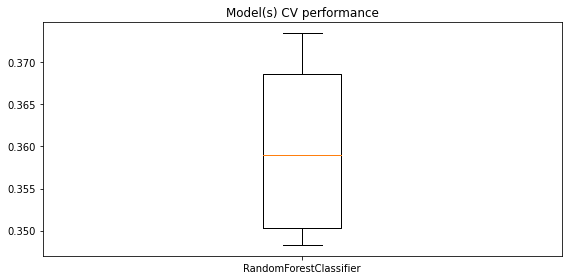

In [16]:
estimators_list = [clf]
plot_estimators_cvperf(estimators_list)

In [17]:
clf.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=7,
                       min_samples_split=8, n_estimators=40)

In [18]:
TARGET_NAMES = [x for x in np.unique(y_train['rating'].values)]
TARGET_DICT = {label:i for i,label in enumerate(TARGET_NAMES)}

Classes evaluated: [1, 2, 3, 4, 5]
Correctly classified......: 39316/92661
Accuracy (simple) ........: 0.42
Balanced acc.  ...........: 0.27
Balanced acc. (adjusted)..: 0.09
Acc. norm (Recall avgs) ..: 0.27
Precision = tp / (tp + fp): [0.44 0.48 0.54 0.49 0.41] -> accuracy of positive predictions
Recall    = tp / (tp + fn): [0.25 0.01 0.01 0.19 0.9 ] -> sensibility (true positive rate)
F1 score .................: [0.32 0.01 0.03 0.27 0.57] -> harmonic mean


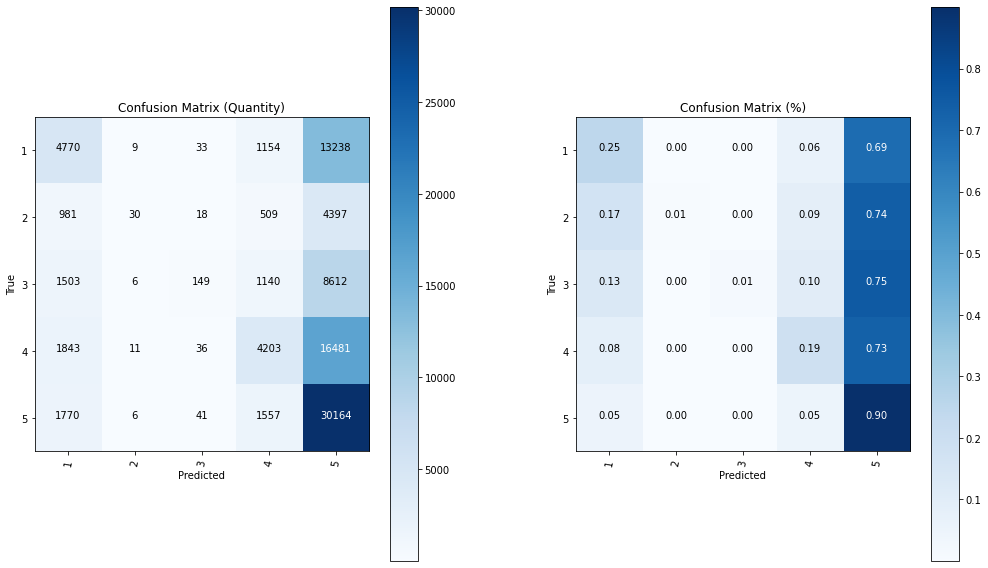

,accuracy,balanced_accuracy,balanced_accuracy adjusted,precision,recall,f1_score
0,0.42,0.27,0.09,0.44,0.25,0.32
1,0.42,0.27,0.09,0.48,0.01,0.01
2,0.42,0.27,0.09,0.54,0.01,0.03
3,0.42,0.27,0.09,0.49,0.19,0.27
4,0.42,0.27,0.09,0.41,0.90,0.57


In [19]:
y_pred_train = [TARGET_DICT[x] for x in clf.best_estimator_.predict(x_train_encoded)]
y_true_train = [TARGET_DICT[x] for x in y_train['rating'].values]

results = ev.performance_measures(y_true_train, y_pred_train, TARGET_NAMES)
results = pd.DataFrame(results)
results

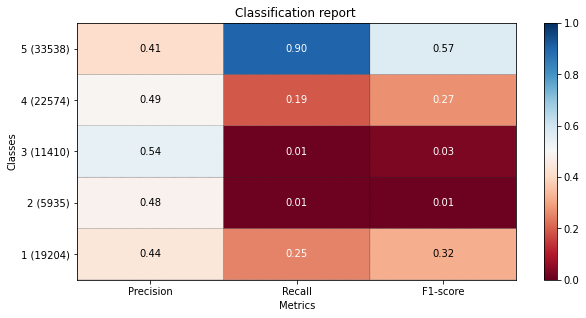

In [20]:
ev.plot_classification_report(classification_report(y_true_train, y_pred_train, target_names=[str(x) for x in TARGET_NAMES]))

In [21]:
# Re-fiting the best estimator in all data:
model = clf.best_estimator_.fit(x_train_encoded, y_train)
model

<ipython-input-21-e725a87dad6c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = clf.best_estimator_.fit(x_train_encoded, y_train)


RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=7,
                       min_samples_split=8, n_estimators=40)

# Submission

In [23]:
df_submission = pd.DataFrame({"id": [i for i in range(x_test_encoded.shape[0])],
                           "rating": clf.best_estimator_.predict(x_test_encoded)})
df_submission

,id,rating
0,0,5
1,1,1
2,2,5
3,3,5
4,4,5
...,...,...
39707,39707,5
39708,39708,5
39709,39709,1
39710,39710,4


In [24]:
submition_file = './submition_file.csv'
df_submission.to_csv(submition_file, index=False)

In [25]:
# !kaggle competitions list

In [26]:
# !kaggle competitions submit -c i2a2-nlp-2021-sentiment-analysis -f submition_file.csv -m "Model 01: Baseline"